### Importing Utility Packages

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
from distutils.dir_util import copy_tree
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import tarfile, os
import numpy as np
import shutil

from google.colab import drive
drive.mount('/content/drive')

### Downloading Training Data to the Server

In [2]:
shutil.copy(src = '/content/drive/MyDrive/datasets-projeto/chexpert-v10-small.zip', 
            dst = '/content/')

shutil.unpack_archive(filename = '/content/chexpert-v10-small.zip', 
                      extract_dir = '', format = 'zip')

os.remove(path = '/content/chexpert-v10-small.zip')

In [ ]:
copy_tree(src = '/content/drive/MyDrive/datasets-projeto/nih-files', 
          dst = '/content/nih-files/')

extract_files = os.listdir('/content/nih-files')

for files in extract_files:
  print(f'Extraindo /content/nih-files/{files}')
  file_ = tarfile.open(f'/content/nih-files/{files}')
  file_.extractall('/content/')
  file_.close()
  os.remove(f'/content/nih-files/{files}')

shutil.rmtree(path = '/content/nih-files')

In [4]:
shutil.copy(src = '/content/drive/MyDrive/datasets-projeto/vinbigdata-dataset.zip', 
            dst = '/content/')

shutil.unpack_archive(filename = '/content/vinbigdata-dataset.zip', 
                      extract_dir = '', format = 'zip')

os.remove(path = '/content/vinbigdata-dataset.zip')

### Organizing and Analyzing Data

In [6]:
dataset = pd.read_csv('/content/all_datasets.csv', index_col = 0)
dataset_diseases = dataset[((dataset['Opacity'] == 1.0) | 
                            (dataset['Atelectasis'] == 1.0) | 
                            (dataset['Pneumothorax'] == 1.0) | 
                            (dataset['Effusion'] == 1.0)) & 
                            (dataset['Nodule/Mass'] == 0.0) &
                            (dataset['No Finding'] == 0.0)].copy()

dataset_diseases.drop(labels = 'Nodule/Mass', axis = 1, inplace = True)
dataset_diseases.drop(labels = 'No Finding', axis = 1, inplace = True)
labels = ['Opacity', 'Atelectasis', 'Pneumothorax', 'Effusion']

dataset_no_diseases = dataset[dataset['No Finding'] == 1.0].copy()

dataset_diseases['Abnormal'] = 1.0
dataset_no_diseases['Abnormal'] = 0.0

dataset = pd.concat((dataset_diseases, dataset_no_diseases))

In [7]:
findings = ['Opacity', 'Atelectasis', 'Pneumothorax', 'Effusion', 'No Finding']
findings_pt = ['Opacidade', 'Atelectasia', 'Pneumotórax', 'Efusão', 'Normal']

Text(0, 0.5, 'Imagens')

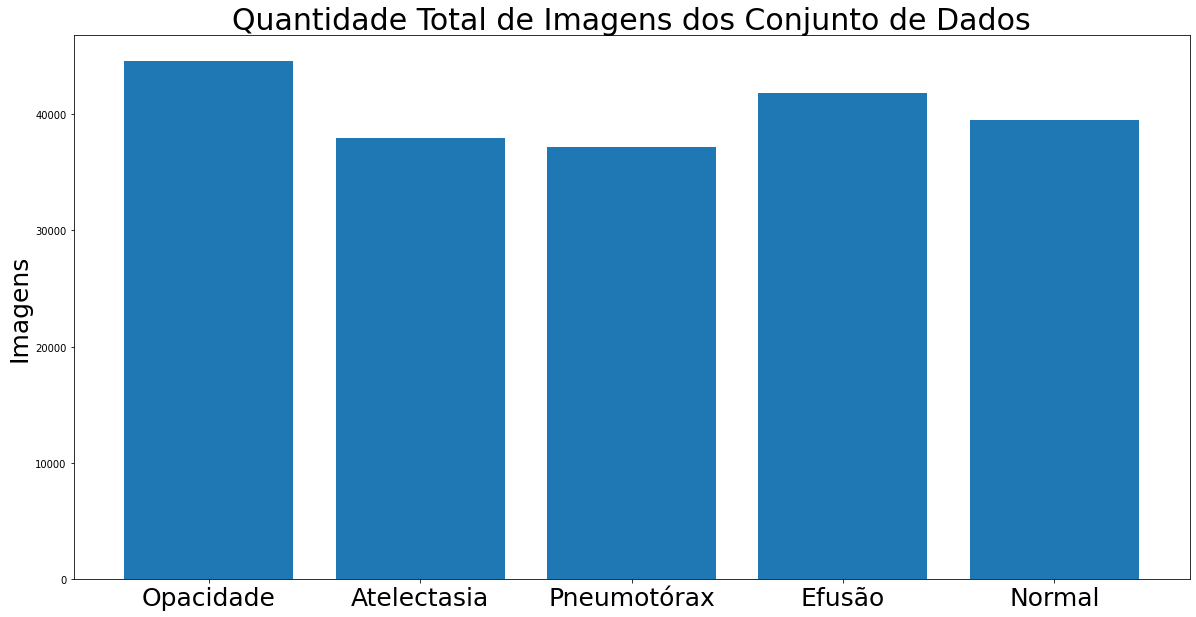

In [8]:
count_findings = list()
for finding in findings:
  count = dict(dataset[finding].value_counts())[1.0]
  count_findings.append(count)

plt.figure(figsize = (20, 10))
plt.bar(findings_pt, count_findings)
plt.xticks(rotation = 0, size = 25)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 25)

In [9]:
opacity = np.array(dataset_diseases['Opacity']).astype(str)
atelectasis = np.array(dataset_diseases['Atelectasis']).astype(str)
pneumothorax = np.array(dataset_diseases['Pneumothorax']).astype(str)
effusion = np.array(dataset_diseases['Effusion']).astype(str)

all_labels = np.zeros(effusion.shape).astype(str)
for index in range(0, len(opacity)):
  all_labels[index] = opacity[index] + atelectasis[index] + pneumothorax[index]
  all_labels[index] += effusion[index]

dataset_diseases['labels_ref'] = all_labels

In [10]:
_, dataset_diseases = train_test_split(dataset_diseases, test_size = 0.45011, 
                                       random_state = 42, 
                                       stratify = dataset_diseases['labels_ref'])

dataset = pd.concat((dataset_diseases, dataset_no_diseases))

Text(0, 0.5, 'Imagens')

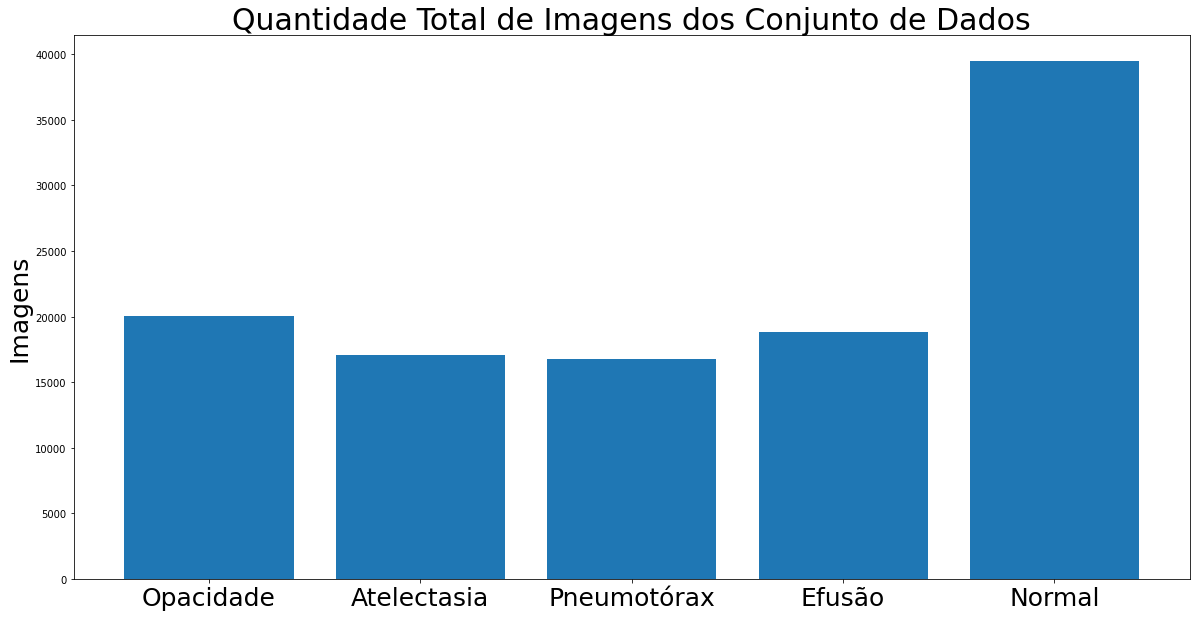

In [11]:
count_findings = list()
for finding in findings:
  count = dict(dataset[finding].value_counts())[1.0]
  count_findings.append(count)

plt.figure(figsize = (20, 10))
plt.bar(findings_pt, count_findings)
plt.xticks(rotation = 0, size = 25)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 25)

Text(0, 0.5, 'Imagens')

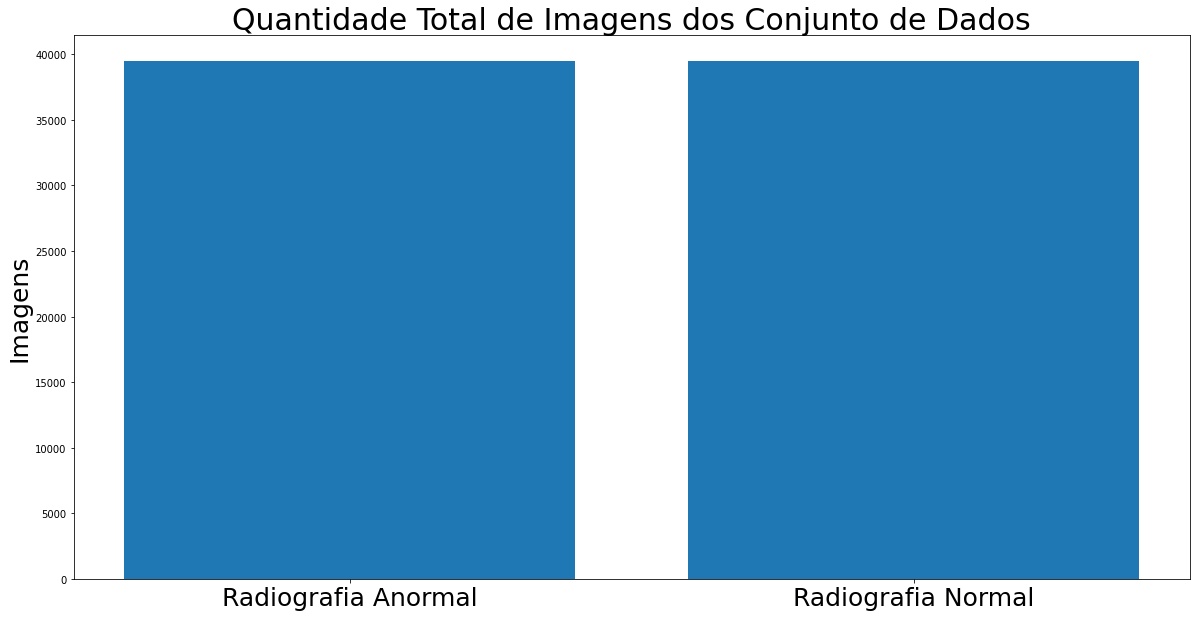

In [12]:
count_findings = list()
count_findings.append(dict(dataset['Abnormal'].value_counts())[1.0])
count_findings.append(dict(dataset['Abnormal'].value_counts())[0.0])

plt.figure(figsize = (20, 10))
plt.bar(['Radiografia Anormal', 'Radiografia Normal'], count_findings)
plt.xticks(rotation = 0, size = 25)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 25)

In [13]:
f_train, f_val = train_test_split(dataset, test_size = 0.2, random_state = 42, 
                                  stratify = dataset['Abnormal'])
f_val, f_test = train_test_split(f_val, test_size = 0.5, random_state = 42, 
                                 stratify = f_val['Abnormal'])

f_train.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_val.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_test.drop(labels = ['labels_ref'], axis = 1, inplace = True)

Text(0, 0.5, 'Imagens')

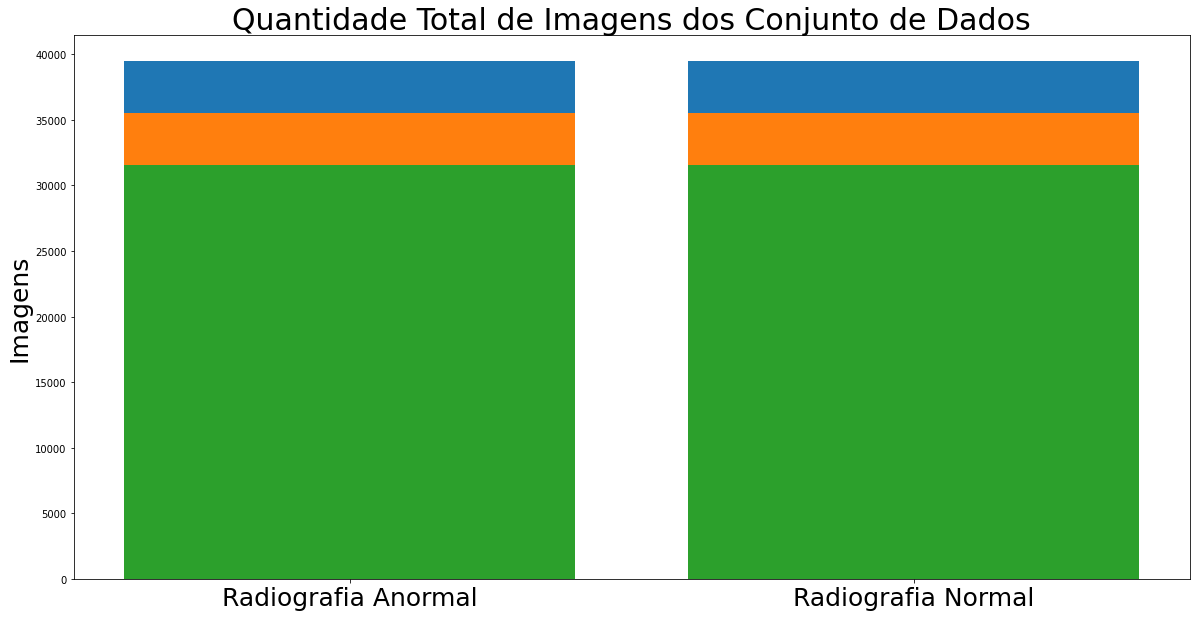

In [14]:
count_train, count_val, count_test = [], [], []
count_train.append(dict(f_train['Abnormal'].value_counts())[1.0])
count_train.append(dict(f_train['Abnormal'].value_counts())[0.0])
count_val.append(dict(f_val['Abnormal'].value_counts())[1.0])
count_val.append(dict(f_val['Abnormal'].value_counts())[0.0])
count_test.append(dict(f_test['Abnormal'].value_counts())[1.0])
count_test.append(dict(f_test['Abnormal'].value_counts())[0.0])

plt.figure(figsize = (20, 10))
plt.bar(['Radiografia Anormal', 'Radiografia Normal'], 
        np.sum((count_train, count_val, count_test), axis = 0))
plt.bar(['Radiografia Anormal', 'Radiografia Normal'], 
        np.sum((count_train, count_val), axis = 0))
plt.bar(['Radiografia Anormal', 'Radiografia Normal'], count_train)

plt.xticks(rotation = 0, size = 25)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 25)

### Keras Data Generator

In [15]:
image_size, batch_size = 256, 64
labels = ['Abnormal']

In [16]:
core_idg = ImageDataGenerator(rescale = 1/255., 
                              shear_range = 0.1, zoom_range = 0.15,
                              rotation_range = 5, width_shift_range = 0.1, 
                              height_shift_range = 0.05, fill_mode = 'constant')

train_gen = core_idg.flow_from_dataframe(dataframe = f_train, directory = None, 
                                         x_col = 'Path', y_col = labels, 
                                         class_mode = 'raw', 
                                         batch_size = batch_size,
                                         target_size = (image_size, image_size), 
                                         shuffle = True)

core_idg = ImageDataGenerator(rescale = 1/255.)

valid_gen = core_idg.flow_from_dataframe(dataframe = f_val, directory = None, 
                                         x_col = 'Path',  y_col = labels, 
                                         class_mode = 'raw', 
                                         batch_size = batch_size,
                                         target_size = (image_size, image_size),
                                         shuffle = False)

test_gen = core_idg.flow_from_dataframe(dataframe = f_test, directory = None, 
                                        x_col = 'Path', y_col = labels, 
                                        class_mode = 'raw', batch_size = batch_size,
                                        target_size = (image_size, image_size),
                                        shuffle = False)

y_labels_valid = valid_gen.labels
y_labels_test = test_gen.labels

Found 63160 validated image filenames.
Found 7895 validated image filenames.
Found 7895 validated image filenames.


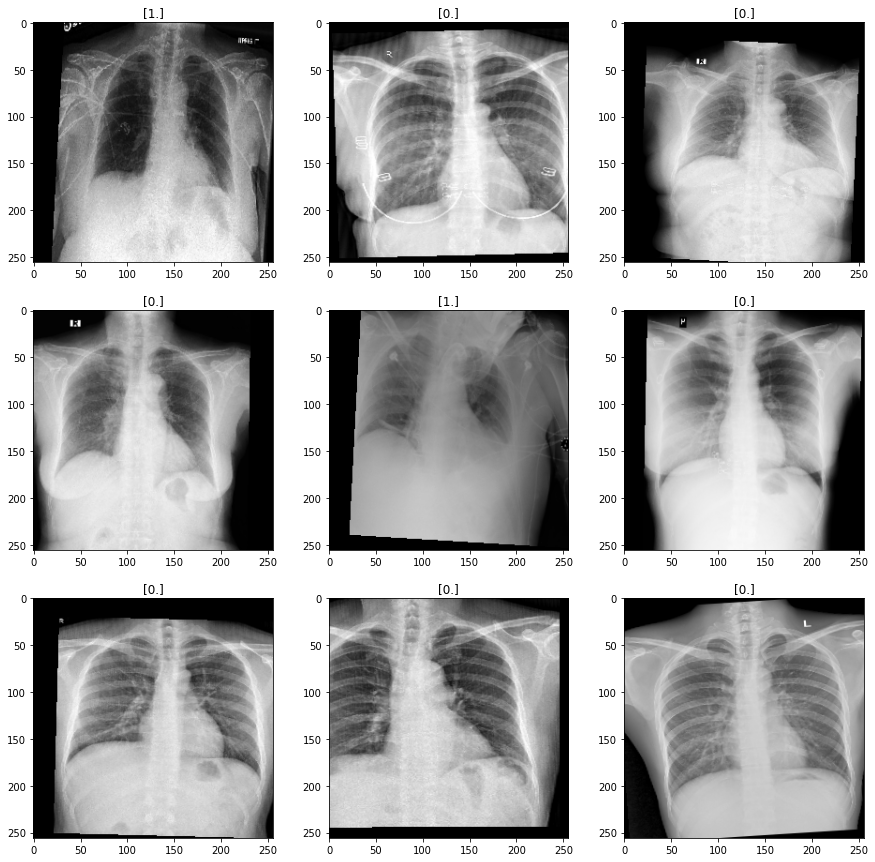

In [17]:
(x,y) = train_gen[0]
fig, axs = plt.subplots(3, 3, figsize = (15, 15))
count = 0
for i in range(0,3):
  for j in range(0,3):
    axs[i,j].set_title(str(y[count]))
    axs[i,j].imshow(x[count])
    count +=1

### Organizing a Callback Utility Function

In [18]:
def get_callbacks(model_name, csv_filename, monitor = 'val_acc',):
    '''
    creates a list of useful callbacks for training the network

    Args:
        model_name (str) --> model name under review
        monitor (str) --> callback analysis metrics
        csv_filename (str) --> log csv file name

    Returns:
        callbacks (list) --> callback list
    '''
    checkpoint_file = f'model.{model_name}.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_file,
                                                    verbose = 1, 
                                                    save_best_only = True, 
                                                    monitor = monitor, 
                                                    mode = 'max')
    csv_logger = tf.keras.callbacks.CSVLogger(csv_filename, separator = ",", 
                                              append = False)
    
    return [checkpoint, csv_logger]

### Defining a Layer Freezing Method

In [19]:
def freeze_layers(conv_base, layer_name):
  '''
  freeze layers of convolutional neural network training

  Args:
    conv_base (tensor) --> convolutional layers of the model
    layer_name (str) --> name of the freezing weight boundary layer
  '''

  conv_base.trainable = True
  set_trainable = False

  for layer in conv_base.layers:
    if layer.name == layer_name: set_trainable = True
    if set_trainable: layer.trainable = True
    else: layer.trainable = False
  
  return None

### DenseNet121

In [ ]:
base_model = InceptionV3(include_top = False, weights = 'imagenet', 
                         input_shape = (image_size, image_size, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(x)
inception = tf.keras.Model(base_model.input, output)
inception.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                 loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                metrics = [tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('inception', 'inception.csv' ,'val_auc')

In [21]:
layers_name = list()
for layer in base_model.layers:
  layers_name.append(layer.name)

block_names = ['input_1', 'activation_18', 'batch_normalization_30', 
               'conv2d_58', 'mixed8']

for blocks in block_names:
  try:
    layers_name.index(blocks)
    print('Bloco ' + blocks + ' found!')
  except ValueError:
    print('Bloco ' + blocks + ' not found!')

Bloco input_1 found!
Bloco activation_18 found!
Bloco batch_normalization_30 found!
Bloco conv2d_58 found!
Bloco mixed8 found!


In [22]:
freeze_layers(conv_base = base_model, layer_name = block_names[4])
inception.summary()

In [23]:
inception.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
              validation_data = valid_gen, epochs = 2, callbacks = callbacks,
              use_multiprocessing = True, workers = 8)

Epoch 1/2
987/986 [==============================] - ETA: 0s - loss: 0.2409 - auc: 0.9623
Epoch 1: val_auc improved from -inf to 0.96815, saving model to model.inception.h5
986/986 [==============================] - 1100s 1s/step - loss: 0.2409 - auc: 0.9623 - val_loss: 0.2632 - val_auc: 0.9681
Epoch 2/2
987/986 [==============================] - ETA: 0s - loss: 0.2096 - auc: 0.9704
Epoch 2: val_auc did not improve from 0.96815
986/986 [==============================] - 1064s 1s/step - loss: 0.2096 - auc: 0.9704 - val_loss: 0.3575 - val_auc: 0.9654


In [ ]:
inception.load_weights('/content/model.inception.h5')
inception.save('model_inception1')
shutil.make_archive(base_name = 'model_inception1', format = 'zip', 
                    root_dir = '/content/model_inception1')
shutil.move('/content/model_inception1.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection')

In [25]:
freeze_layers(conv_base = base_model, layer_name = block_names[2])
inception.summary()

In [26]:
inception.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
              validation_data = valid_gen, epochs = 2, callbacks = callbacks,
              use_multiprocessing = True, workers = 8)

Epoch 1/2
987/986 [==============================] - ETA: 0s - loss: 0.2181 - auc: 0.9679
Epoch 1: val_auc improved from 0.96815 to 0.97094, saving model to model.inception.h5
986/986 [==============================] - 1061s 1s/step - loss: 0.2181 - auc: 0.9679 - val_loss: 0.2753 - val_auc: 0.9709
Epoch 2/2
987/986 [==============================] - ETA: 0s - loss: 0.2002 - auc: 0.9725
Epoch 2: val_auc did not improve from 0.97094
986/986 [==============================] - 1071s 1s/step - loss: 0.2002 - auc: 0.9725 - val_loss: 0.2151 - val_auc: 0.9697


In [ ]:
inception.load_weights('/content/model.inception.h5')
inception.save('model_inception2')
shutil.make_archive(base_name = 'model_inception2', format = 'zip', 
                    root_dir = '/content/model_inception2')
shutil.move('/content/model_inception2.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection')

In [28]:
freeze_layers(conv_base = base_model, layer_name = block_names[0])
inception.summary()

In [29]:
inception.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
              validation_data = valid_gen, epochs = 2, callbacks = callbacks,
              use_multiprocessing = True, workers = 8)

Epoch 1/2
987/986 [==============================] - ETA: 0s - loss: 0.2055 - auc: 0.9712
Epoch 1: val_auc did not improve from 0.97094
986/986 [==============================] - 1118s 1s/step - loss: 0.2055 - auc: 0.9712 - val_loss: 0.2332 - val_auc: 0.9654
Epoch 2/2
987/986 [==============================] - ETA: 0s - loss: 0.1949 - auc: 0.9737
Epoch 2: val_auc improved from 0.97094 to 0.97385, saving model to model.inception.h5
986/986 [==============================] - 1078s 1s/step - loss: 0.1949 - auc: 0.9737 - val_loss: 0.2057 - val_auc: 0.9738


In [ ]:
inception.load_weights('/content/model.inception.h5')
inception.save('model_inception3')
shutil.make_archive(base_name = 'model_inception3', format = 'zip', 
                    root_dir = '/content/model_inception3')
shutil.move('/content/model_inception3.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection')

In [ ]:
shutil.move('/content/model.inception.h5', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection')

In [ ]:
csv_log1 = pd.read_csv('/content/inception1.csv')
csv_log2 = pd.read_csv('/content/inception2.csv')
csv_log3 = pd.read_csv('/content/inception3.csv')

csv_log = pd.concat([csv_log1, csv_log2, csv_log3])

csv_log.reset_index(inplace = True)
csv_log.drop(['index', 'epoch'], axis = 1, inplace = True)
csv_log.to_csv(path_or_buf = 'inception_log.csv', sep = ',')

shutil.move('/content/inception_log.csv', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection')

### Evaluative Metrics of the Trained Model

In [33]:
def binarize_preds(pred_array, column, threshold):
  '''
  function that binarizes multi-label prediction labels from a threshold

  Args:
    pred_array (array) --> array with multi-label predictions
    column (int) --> column under analysis
    threshold (float) --> Binarization threshold for the column under analysis
  
  Returns:
    pred_bin (array) --> array with the binarized predictions of the column 
    under analysis
  '''
  per_100 = pred_array[:,column] * 100
  pred_bin = list()
  for value in per_100:
    if value >= threshold: pred_bin.append(1)
    else: pred_bin.append(0)
  
  return pred_bin

In [34]:
y_pred_val = inception.predict(valid_gen)
y_pred = inception.predict(test_gen)
print(f'AUC | Dados de Validação = {inception.evaluate(valid_gen)[1] * 100} %')
print(f'AUC | Dados de Teste = {inception.evaluate(test_gen)[1] * 100} %')

124/124 [==============================] - 182s 1s/step - loss: 0.2057 - auc: 0.9738
AUC | Dados de Validação = 97.3849892616272 %
124/124 [==============================] - 181s 1s/step - loss: 0.2104 - auc: 0.9733
AUC | Dados de Teste = 97.32788801193237 %


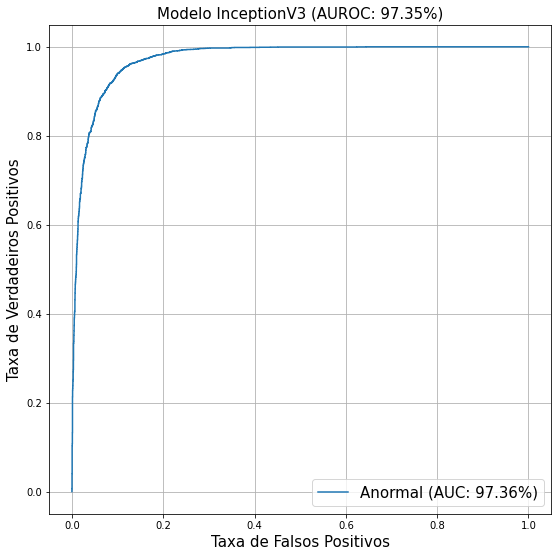

In [35]:
labels_portugues = ['Anormal']
fig, c_ax = plt.subplots(1, 1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(y_labels_test[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label = '{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize = 15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
auroc_value = str(roc_auc_score(y_labels_test.astype(int), y_pred)*100)[0:5]
c_ax.set_title('Modelo InceptionV3 (AUROC: ' + auroc_value + '%)', size = 15)
c_ax.grid(True)

In [36]:
threshold_variation = dict()
for label_index in range(0, len(labels)):
  threshold_variation[label_index] = list()
  for threshold in range(1, 100):
    y_pred_bin = binarize_preds(pred_array = y_pred_val, column = label_index, 
                                threshold = threshold)
    matrix = confusion_matrix(y_labels_valid[:, label_index], y_pred_bin)
    precision = matrix[0,0] / (matrix[0,0]+matrix[0,1])
    recall = matrix[0,0] / (matrix[0,0]+matrix[1,0])
    f1_score = (2 * precision*recall) / (precision + recall) 
    threshold_variation[label_index].append(f1_score)

bests_thresholds = list()
for label_index in range(0, len(labels)):
   for threshold in range(1, 100):
     if threshold_variation[label_index][threshold] == np.max(threshold_variation[label_index]):
       bests_thresholds.append(threshold)
       break

In [37]:
for label_index in range(0,1):
  y_pred_bin = binarize_preds(pred_array = y_pred, column = label_index, 
                              threshold = bests_thresholds[label_index])
  matrix = confusion_matrix(y_labels_test[:, label_index], y_pred_bin)
  acc = (matrix[0,0] + matrix[1,1])/np.sum(matrix)
  precision = matrix[0,0]/(matrix[0,0]+matrix[0,1])
  recall = matrix[0,0]/(matrix[0,0]+matrix[1,0])
  f1_score = (2*precision*recall) / (precision + recall) 
  print(f'=={labels_portugues[label_index]}== \n{matrix},' 
        f' Threshold = {bests_thresholds[label_index]}'
        f'\nAcurácia = {acc*100} % | Precisão = {precision*100} % | '
        f'\nSensibilidade = {recall*100} % | F1 Score = {f1_score*100} %\n')

==Anormal== 
[[3567  381]
 [ 257 3690]], Threshold = 42
Acurácia = 91.91893603546548 % | Precisão = 90.34954407294833 % | 
Sensibilidade = 93.27928870292888 % | F1 Score = 91.7910447761194 %

